# ANALYSE ET TRAITEMENT DES DONNEES

Ce fichier a vocation à présenter l'intégralité du code utiliser pour analyser, étudier et traiter la donnée afin de la préparer avant la modélisation

## INITIALISATION

#### IMPORT DES LIBRAIRIES

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

c:\users\nicom\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\users\nicom\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def WOE_IV_RUNNING(i):
    X = pd.crosstab(df[i],df.default_time)
    tot_gd= X.iloc[0].sum()
    tot_bd=X.iloc[1].sum()
    X['dist bad']=X.iloc[1]/tot_bd
    X['dist gd']=X.iloc[0]/tot_gd
    X['WoE'] = np.log(X['dist gd']/X['dist bad'])
    X['IV'] = (X['dist gd']-X['dist bad']) * X['WoE']
    proof = X['IV'].sum()
    if proof<0.05:
        print(i,' l IV vaut : ', proof,'à ne pas garder')
    else :
        print(i,' l IV vaut : ', proof,'à garder')

In [3]:
def IV_WoE_Coarse(df,var,label,tar, pr=False):
    
    lst = []
    df[var] = df[var].fillna("NULL")

    for i in range(df[var].nunique()):
        val = list(df[var].unique())[i]
        val_1 = list(df[label].unique())[i]
        lst.append([val,                                                 # Variable
                    val_1,                                                 # Modalité
                    df[df[var] == val].count()[var],                     # Total
                    df[(df[var] == val) & (tar == 0)].count()[var],  # Good
                    df[(df[var] == val) & (tar == 1)].count()[var]]) # Bad
    
    data = pd.DataFrame(lst, columns=['Groupes', 'Labels', 'Total', 'Not Converted', 'Converted'])

    data['Share'] = data['Total'] / data['Total'].sum()
    data['Converted Rate'] = data['Converted'] / data['Total']
    data['Distribution Not Converted'] = (data['Total'] - data['Converted']) / (data['Total'].sum() - data['Converted'].sum())
    data['Distribution Converted'] = data['Converted'] / data['Converted'].sum()
    data['WoE'] = np.log(data['Distribution Converted'] / data['Distribution Not Converted'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Converted'] - data['Distribution Not Converted'])
    data['sum'] = data['IV'].sum()

    data = data.sort_values(by=['Groupes', 'Labels'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

### import des données

In [4]:
import pandas as pd
filename=r"C:\Users\nicom\OneDrive\Bureau\Master\Credit Risk\mortgage.csv"
df = pd.read_csv(filename) 
df.sort_values(by='time',ascending=False,inplace=True)
df.drop_duplicates(subset='id',inplace=True)

## ANALYSE
Dans cette partie nous nous attacherons à étudier les données et leur valeurs pour comprendre comment les variables interagissent. Nous nous attacherons à étudier de façon distincte les variables qui évoluent en fonction du temps aux informations récupérée à l'origination de l'obligation

### VARIABLES FIGEES

In [5]:
df.drop(['id','time','first_time','mat_time','balance_time','LTV_time','interest_rate_time','hpi_time','gdp_time','uer_time'],axis=1,inplace=True)

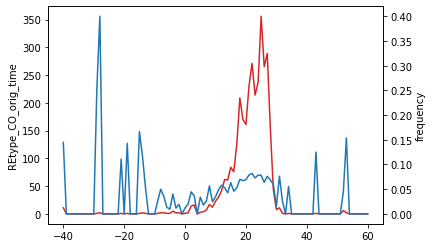

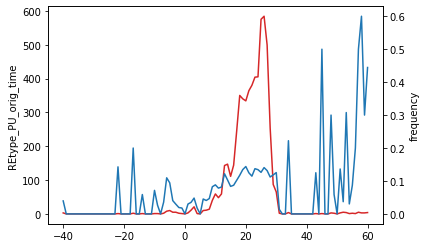

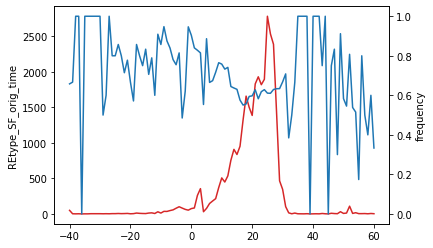

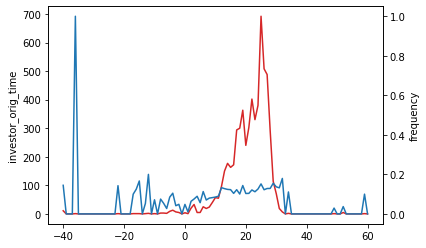

In [6]:
var = ['REtype_CO_orig_time','REtype_PU_orig_time','REtype_SF_orig_time','investor_orig_time']
for i in var:
    x = pd.crosstab(df.orig_time,df[i])
    x['total']=x[[0]].values+x[[1]].values
    x['frequency']=x[[1]].values/x[['total']].values
    fig,ax1 = plt.subplots()
    ax1.set_ylabel(i)
    color = 'tab:red'
    ax1.plot(x[[1]],color=color)
    ax2=ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('frequency')
    ax2.plot(x[['frequency']],color=color)
    plt.show()
    

In [7]:
control = df.groupby('orig_time').mean()
control.describe()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,0.036996,0.076543,0.704985,0.063887,282750.971806,664.039464,77.995698,6.323804,134.007041,0.154750,0.489308,1.133367
std,0.058999,0.115486,0.217743,0.112040,271013.229229,69.680093,6.354324,2.451042,49.712818,0.158120,0.283161,0.572547
min,0.000000,0.000000,0.000000,0.000000,20005.500000,516.000000,52.700000,0.000000,75.710000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.600000,0.000000,97728.306607,609.935833,74.925000,4.601089,80.535000,0.000000,0.253724,0.888393
50%,0.012873,0.035373,0.715476,0.039229,168950.750294,660.007318,79.538345,5.839928,140.400000,0.129472,0.500000,1.230143
75%,0.056389,0.116656,0.839821,0.109543,312289.275026,696.741758,81.204286,8.067126,173.305000,0.243750,0.712488,1.558733
max,0.400000,0.600000,1.000000,1.000000,986967.250000,818.000000,96.800000,12.750000,226.290000,0.562500,1.000000,2.000000


<AxesSubplot:xlabel='orig_time'>

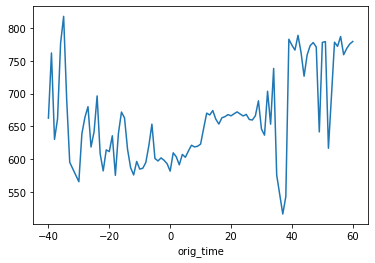

In [8]:
control.FICO_orig_time.plot()

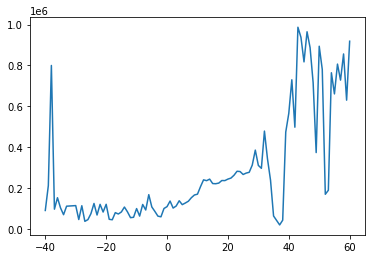

{'whiskers': [<matplotlib.lines.Line2D at 0x29135f97f10>,
 'caps': [<matplotlib.lines.Line2D at 0x29135fa34f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29135f97c40>],
 'medians': [<matplotlib.lines.Line2D at 0x29135fa3a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x29135fa3d60>],
 'means': []}

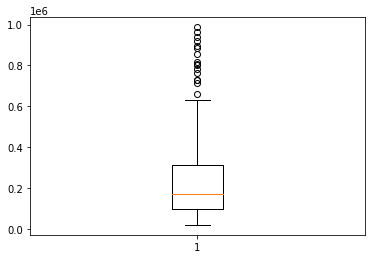

In [9]:
plt.plot(control['balance_orig_time'])
plt.show()
plt.boxplot(control.balance_orig_time)

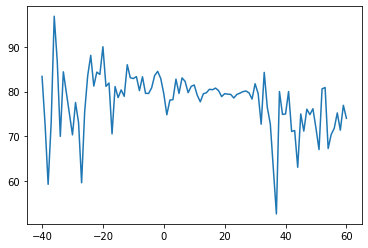

In [10]:
plt.plot(control['LTV_orig_time'])
plt.show()

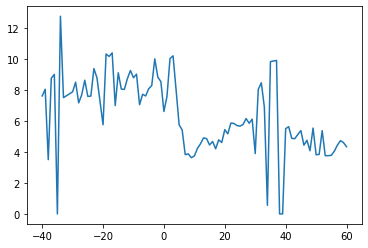

In [11]:
plt.plot(control['Interest_Rate_orig_time'])

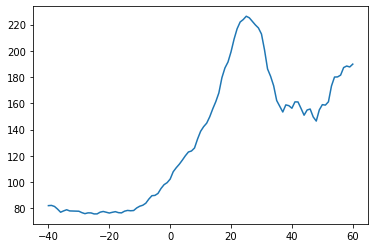

In [12]:
plt.plot(control['hpi_orig_time'])

### VARIABLES EVOLUTIVES

In [13]:
df = pd.read_csv(filename) 
df.sort_values(by='time',ascending=False,inplace=True)
df.drop_duplicates(subset='id',keep='first',inplace=True)
df = df[df['status_time']!=0]
df.drop(['status_time','payoff_time'],axis=1,inplace=True)
df = df[df['balance_time']<=np.quantile(df['balance_time'],0.999)]
df = df[df['LTV_time']>=0]

In [14]:
df = df[['time','first_time','mat_time','balance_time','LTV_time','interest_rate_time','hpi_time','gdp_time','uer_time']]

In [15]:
control = df.groupby('time').mean()
control.describe()

,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,19.746917,132.656261,220676.140650,78.627358,7.617483,168.397833,1.844933,6.388333
std,9.909749,10.076662,56585.044135,15.676427,1.634750,31.835036,1.800838,1.806869
min,1.000000,108.912281,103949.300702,61.415416,5.417465,107.830000,-4.146711,3.800000
25%,11.514999,124.424041,190847.683169,64.990481,6.185335,150.607500,1.259076,5.000000
50%,25.411059,137.714832,232877.508221,71.320383,7.289210,161.095000,2.190616,5.800000
75%,26.589858,140.659038,264247.789014,94.058697,8.541500,187.830000,2.876230,7.850000
max,31.662088,143.262796,290041.663892,109.644039,10.813649,226.290000,5.132464,10.000000


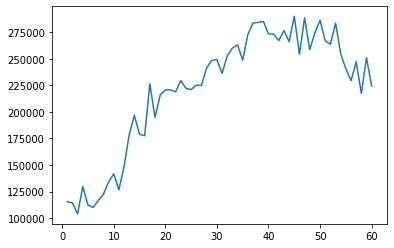

In [16]:
plt.plot(control.balance_time)

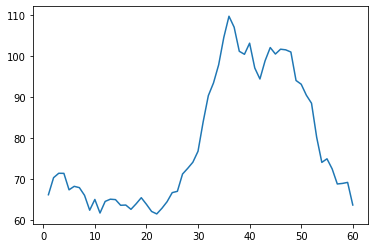

In [17]:
plt.plot(control.LTV_time)

<AxesSubplot:xlabel='time'>

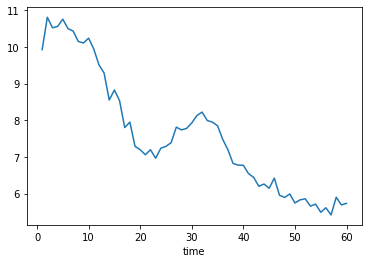

In [18]:
control.interest_rate_time.plot()

<AxesSubplot:xlabel='time'>

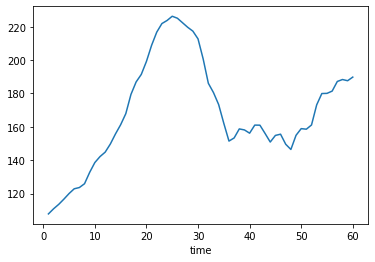

In [19]:
control.hpi_time.plot()

<AxesSubplot:xlabel='time'>

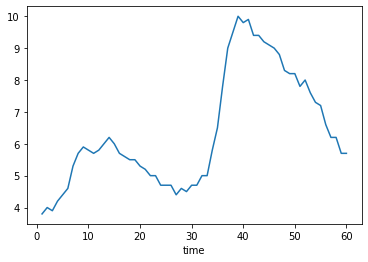

In [20]:
control.uer_time.plot()

### variable cible

In [21]:
df = pd.read_csv(filename) 
df.sort_values(by='time',ascending=False,inplace=True)
df.drop_duplicates(subset='id',keep='first',inplace=True)
df = df[df['balance_time']<=np.quantile(df['balance_time'],0.999)]
df = df[df['LTV_time']>=0]

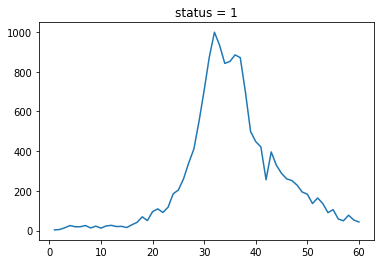

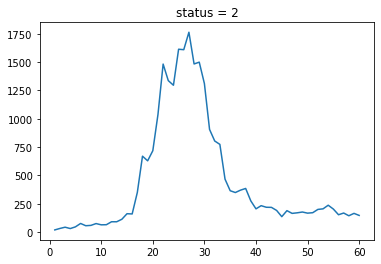

In [22]:
df['status = 0'] = np.where((df.status_time==0),1,0)
df['status = 1'] = np.where((df.status_time==1),1,0)
df['status = 2'] = np.where((df.status_time==2),1,0)
control = df.groupby('time').sum()
plt.plot(control['status = 1'])
plt.title('status = 1')
plt.show()
plt.plot(control['status = 2'])
plt.title('status = 2')
plt.show()

### Description du profil type du mauvais payeur

In [23]:
df = pd.read_csv(filename) 
df.sort_values(by='time',ascending=False,inplace=True)
df.drop_duplicates(subset='id',keep='first',inplace=True)
df = df[df['status_time']==1]
df.drop(['status_time','payoff_time','default_time'],axis=1,inplace=True)
df = df[df['balance_time']<=np.quantile(df['balance_time'],0.999)]
df = df[df['LTV_time']>=0]

In [24]:
df.describe()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time
count,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,1.513300e+04,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,15133.000000,1.513300e+04,15133.000000,15133.000000,15133.000000,15133.000000
mean,24825.986718,35.695764,22.898698,26.145378,142.844182,2.503713e+05,96.941391,7.548562,176.685883,0.552329,6.852653,0.067468,0.122117,0.623009,0.129518,2.514645e+05,648.939404,81.040104,5.882178,209.447823
std,14512.816160,8.719963,6.273619,5.558500,13.790938,1.797491e+05,21.845635,2.022211,25.457944,2.310963,2.013925,0.250840,0.327432,0.484649,0.335784,1.777439e+05,67.302112,8.473589,3.326246,28.091494
min,1.000000,1.000000,-40.000000,1.000000,35.000000,2.883060e+03,3.600425,1.000000,107.830000,-4.146711,3.800000,0.000000,0.000000,0.000000,0.000000,1.595600e+04,413.000000,50.100000,0.000000,75.710000
25%,12006.000000,31.000000,21.000000,24.000000,141.000000,1.192398e+05,82.857610,6.500000,156.040000,-0.314448,5.000000,0.000000,0.000000,0.000000,0.000000,1.215000e+05,604.000000,80.000000,4.750000,208.860000
50%,25578.000000,35.000000,25.000000,27.000000,145.000000,2.029372e+05,98.815687,7.500000,162.090000,1.229172,6.500000,0.000000,0.000000,1.000000,0.000000,2.047200e+05,651.000000,80.000000,6.900000,221.910000
75%,36532.000000,40.000000,27.000000,29.000000,147.000000,3.344800e+05,112.622405,8.750000,200.670000,2.274218,9.000000,0.000000,0.000000,1.000000,0.000000,3.360000e+05,696.000000,85.000000,8.000000,225.100000
max,49972.000000,60.000000,52.000000,53.000000,229.000000,1.536489e+06,175.071039,15.990000,226.290000,5.132464,10.000000,1.000000,1.000000,1.000000,1.000000,1.536500e+06,818.000000,118.200000,15.990000,226.290000


## TRAITEMENT DES DONNEES

In [25]:
df = pd.read_csv(filename)
df.sort_values(by='time',ascending=False,inplace=True)
df.drop_duplicates(subset='id',keep='first',inplace=True)
df = df[df['status_time']!=0]
df.drop(['status_time','payoff_time'],axis=1,inplace=True)
df = df[df['balance_time']<=np.quantile(df['balance_time'],0.999)]
df = df[df['LTV_time']>=0]

In [26]:
X_train,y_train = df,df['default_time']

In [27]:
var_quanti = X_train.dtypes[X_train.dtypes=='float64'].index.tolist()
var_int = X_train.dtypes[X_train.dtypes=='int64'].index.tolist()

### SECTIONNEMENT DES VARIABLES CONTINUS ET ETUDE DE LA WoE

In [28]:
IV1 = {}
for i in var_quanti:
    name = 'q'+i
    X_train[name]=pd.qcut(X_train[i],10,precision=0,labels=False,duplicates='drop')
    name_bis = 'labels'+i
    X_train[name_bis]=pd.qcut(X_train[i],10,precision=0,duplicates='drop')
    IV1[i]=IV_WoE_Coarse(X_train,name,name_bis,y_train,pr=True)[1]

   Groupes                 Labels  Total  Not Converted  Converted     Share  \
0        0        (-1.0, 67905.0]   4169           2909       1260  0.100014   
1        1     (67905.0, 98517.0]   4168           2722       1446  0.099990   
2        2    (98517.0, 126071.0]   4168           2739       1429  0.099990   
3        3   (126071.0, 155569.0]   4169           2720       1449  0.100014   
4        4   (155569.0, 191179.0]   4168           2677       1491  0.099990   
5        5   (191179.0, 232818.0]   4168           2601       1567  0.099990   
6        6   (232818.0, 289769.0]   4169           2499       1670  0.100014   
7        7   (289769.0, 367430.0]   4168           2537       1631  0.099990   
8        8   (367430.0, 485000.0]   4168           2542       1626  0.099990   
9        9  (485000.0, 1719943.0]   4169           2601       1568  0.100014   

   Converted Rate  Distribution Not Converted  Distribution Converted  \
0        0.302231                    0.109579 

9                0.024179 -1.590432  0.150201  0.733009  
IV =  0.7330092714082181
   Groupes                     Labels  Total  Not Converted  Converted  \
0        0  (3.6999999999999997, 4.5]   4391           3436        955   
1        1                 (4.5, 4.7]  10955           8297       2658   
2        2                 (4.7, 5.0]   6538           4398       2140   
3        3                 (5.0, 5.5]   3459           3111        348   
4        4                 (5.5, 6.5]   4824           2686       2138   
5        5                 (6.5, 8.2]   3813           1862       1951   
6        6                 (8.2, 9.4]   4540           1659       2881   
7        7                (9.4, 10.0]   3164           1098       2066   

      Share  Converted Rate  Distribution Not Converted  \
0  0.105340        0.217490                    0.129431   
1  0.262811        0.242629                    0.312540   
2  0.156847        0.327317                    0.165668   
3  0.082981   

LTV_time 1.341278005025778


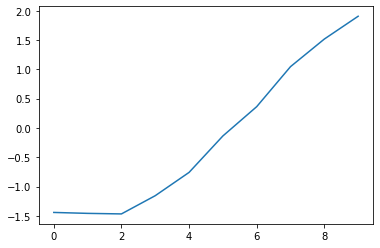

interest_rate_time 0.14175552496288532


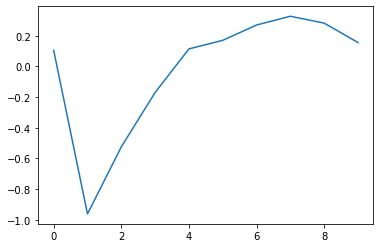

hpi_time 0.6855253523529886


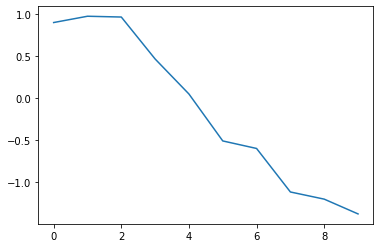

gdp_time 0.7330092714082181


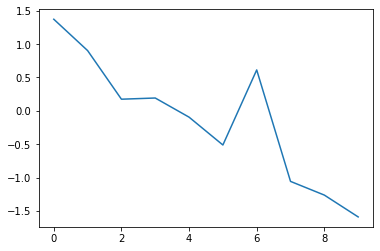

uer_time 0.5889533195775173


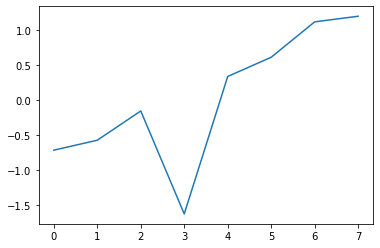

LTV_orig_time 0.09064122294287262


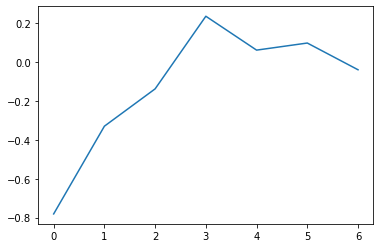

Interest_Rate_orig_time 0.17057607658631968


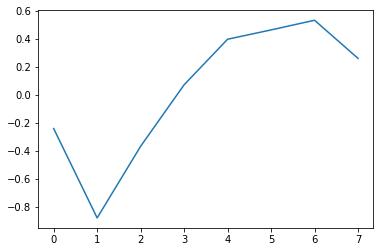

hpi_orig_time 0.7140077302290174


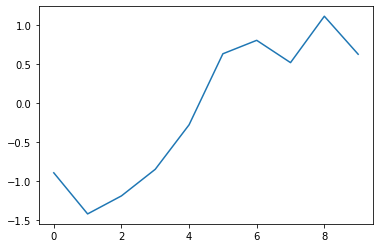

In [29]:
liste_quant = []
for i in var_quanti : 
    x = sum(IV1[i]['IV'])
    if x>0.05:
        print(i,x)
        liste_quant.append(i)
        name = 'q'+i
        liste_quant.append(name)
        name_bis = 'labels'+i
        liste_quant.append(name_bis)
        plt.plot(IV1[i]['WoE'])
        plt.show()

In [30]:
IV2 = {}
for i in var_int:
    name = 'q'+i
    X_train[name]=pd.qcut(X_train[i],10,precision=0,labels=False,duplicates='drop')
    name_bis = 'labels'+i
    X_train[name_bis]=pd.qcut(X_train[i],10,precision=0,duplicates='drop')
    IV2[i]=IV_WoE_Coarse(X_train,name,name_bis,y_train,pr=True)[1]

   Groupes              Labels  Total  Not Converted  Converted     Share  \
0        0       (0.0, 4615.0]   4169           2521       1648  0.100014   
1        1    (4615.0, 9169.0]   4168           2854       1314  0.099990   
2        2   (9169.0, 14288.0]   4168           2632       1536  0.099990   
3        3  (14288.0, 19229.0]   4169           2869       1300  0.100014   
4        4  (19229.0, 24336.0]   4168           2755       1413  0.099990   
5        5  (24336.0, 29114.0]   4168           2458       1710  0.099990   
6        6  (29114.0, 34105.0]   4169           2619       1550  0.100014   
7        7  (34105.0, 39064.0]   4168           2712       1456  0.099990   
8        8  (39064.0, 43769.0]   4168           2914       1254  0.099990   
9        9  (43769.0, 49984.0]   4169           2213       1956  0.100014   

   Converted Rate  Distribution Not Converted  Distribution Converted  \
0        0.395299                    0.094964                0.108872   
1     

   Groupes       Labels  Total  Not Converted  Converted  Share  \
0        0  (-1.0, 1.0]  41684          26547      15137    1.0   

   Converted Rate  Distribution Not Converted  Distribution Converted  WoE  \
0        0.363137                         1.0                     1.0  0.0   

    IV  sum  
0  0.0  0.0  
IV =  0.0
   Groupes       Labels  Total  Not Converted  Converted  Share  \
0        0  (-1.0, 1.0]  41684          26547      15137    1.0   

   Converted Rate  Distribution Not Converted  Distribution Converted  WoE  \
0        0.363137                         1.0                     1.0  0.0   

    IV  sum  
0  0.0  0.0  
IV =  0.0
   Groupes          Labels  Total  Not Converted  Converted     Share  \
0        0  (399.0, 559.0]   4230           2571       1659  0.101478   
1        1  (559.0, 596.0]   4131           2498       1633  0.099103   
2        2  (596.0, 622.0]   4242           2521       1721  0.101766   
3        3  (622.0, 642.0]   4189           2404

time 1.083010120286774


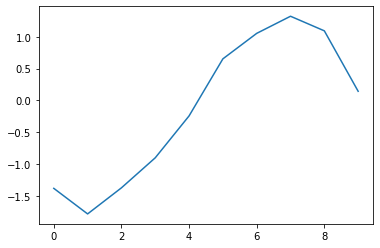

orig_time 0.7978043746148052


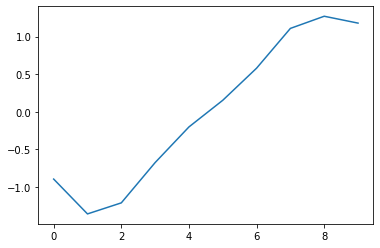

first_time 0.8233572080495108


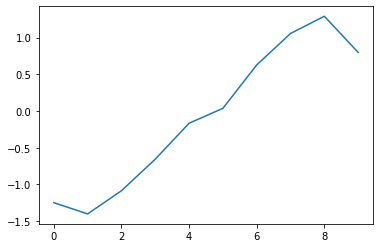

mat_time 0.8499127481067499


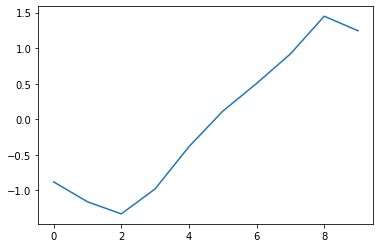

FICO_orig_time 0.10062207403788036


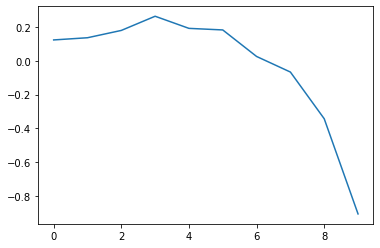

In [31]:
liste_int = []
for i in var_int : 
    x = sum(IV2[i]['IV'])
    if x>0.05:
        print(i,x)
        liste_int.append(i)
        name = 'q'+i
        liste_int.append(name)
        name_bis = 'labels'+i
        liste_int.append(name_bis)
        plt.plot(IV2[i]['WoE'])
        plt.show()

### Contrôle de la pertinence des dummies

In [32]:
#a ne pas garder
a = ['REtype_PU_orig_time','REtype_SF_orig_time','REtype_CO_orig_time','investor_orig_time']
for i in a:
    WOE_IV_RUNNING(i)

REtype_PU_orig_time  l IV vaut :  0.001503397094310994 à ne pas garder
REtype_SF_orig_time  l IV vaut :  5.9557185184667255e-05 à ne pas garder
REtype_CO_orig_time  l IV vaut :  0.0004961458970656801 à ne pas garder
investor_orig_time  l IV vaut :  0.011383276367521048 à ne pas garder


#### liste initiale


1.FICO 
2.mat_time
3.first_time 
4.orig_time
5.time
6.Interest_Rate_orig_time :
7.LTV_time 
8.LTV_orig_time
8.interest_rate_time 
9.hpi_time 
10.gdp_time 
11.uer_time


Text(0.5, 1.0, 'Matrice de Corrélation')

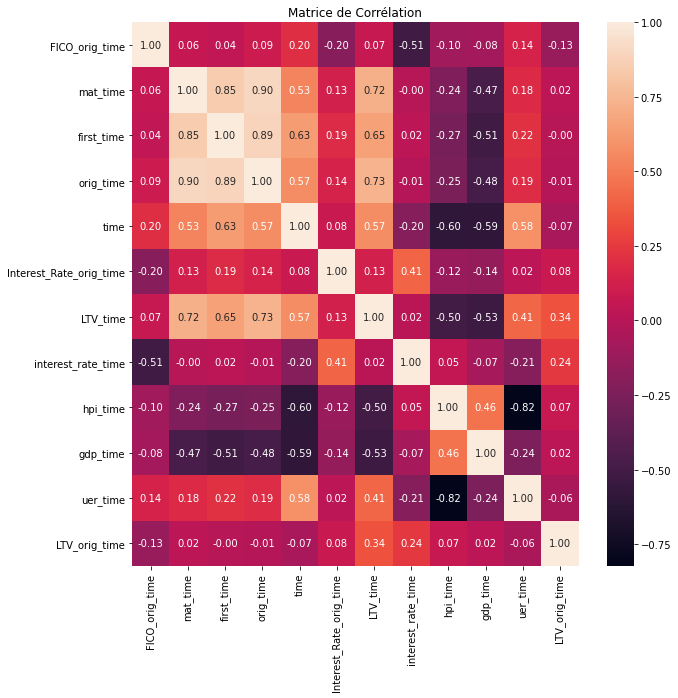

In [33]:
df = df[['FICO_orig_time','mat_time','first_time','orig_time','time','Interest_Rate_orig_time','LTV_time',
         'interest_rate_time','hpi_time','gdp_time','uer_time','LTV_orig_time']]
correlation = df.corr(method='spearman',min_periods = 100) # Spearman méthod car variables catégorielles
plt.figure(figsize=(10,10))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, fmt='.2f')
plt.title('Matrice de Corrélation')

#### problème de corrélation

uer_time/time
mat_time/orig_time
mat_time/first_time
hpi_orig_time/first_time 
mat_time/hpi_orig_time
balance_orig_time/balance_time
hpi_time/uer_time

drop  -> orig_time,first_time,uer_time

Text(0.5, 1.0, 'Matrice de Corrélation')

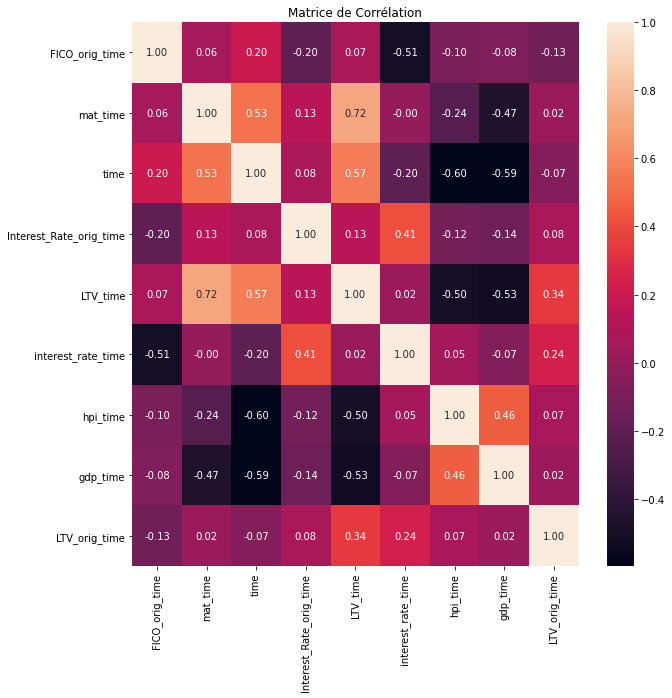

In [34]:
df = df[['FICO_orig_time','mat_time','time','Interest_Rate_orig_time','LTV_time',
         'interest_rate_time','hpi_time','gdp_time','LTV_orig_time']]
correlation = df.corr(method='spearman',min_periods = 100) # Spearman méthod car variables catégorielles
plt.figure(figsize=(10,10))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, fmt='.2f')
plt.title('Matrice de Corrélation')

In [35]:
liste_quant.remove('uer_time')
liste_int.remove('orig_time')
liste_int.remove('first_time')

In [36]:
liste_bis = liste_int+liste_quant
X_train_bis = X_train[liste_bis]

#### Fonction pour redéfinir les intervalles des classes

In [37]:
def WoE_assist(i):
    if i in IV1:
        x = IV1[i][['Labels','WoE']]
        print(i,x)
    else :
        x = IV2[i][['Labels','WoE']]
        print(i,x)  
    plt.plot(x['WoE'])
    plt.show()

In [38]:
for i in []:
    WoE_assist(i)

1.FICO : 0-5,6-7,8-9 ->3
2.mat_time : 0-3,4-6,7-9 ->3
4.Interest_Rate_orig_time : 0-2,3,4-7 -> 3 
5.LTV_time : 0-4,5-6,7-10 -> 3
6.hpi_time : 0-2,3-6,7-9 -> 3
7.gdp_time : 0-1,2-4,5-9 -> 3
8.time : 0-3,4,5-9 ->3
9.interest_rate_time :  0-2,3-9 ->2
10.LTV_orig_time : 0-1,2-6

SUM : 16 Dummies

#### Creation des Dummies

In [39]:
def transform_df(X_train_bis):
    variable_a_garder = ['FICO_orig_time','mat_time','time','Interest_Rate_orig_time','LTV_time',
         'interest_rate_time','hpi_time','gdp_time','LTV_orig_time']
    X_train_bis=X_train_bis[variable_a_garder]
    X_train_bis['FICO : 399-681']=np.where((X_train_bis.FICO_orig_time<=681),1,0)
    X_train_bis['FICO : 682 - 726'] = np.where((X_train_bis.FICO_orig_time>=682) &(X_train_bis.FICO_orig_time<=726),1,0)
    X_train_bis['FICO : 726+ - 840'] = np.where((X_train_bis.FICO_orig_time>726),1,0)
    X_train_bis['mat : <=139'] = np.where((X_train_bis.mat_time<=139),1,0)
    X_train_bis['mat : 140-144'] = np.where((X_train_bis.mat_time>140)&(X_train_bis.mat_time<=144),1,0)
    X_train_bis['mat : >=145'] = np.where((X_train_bis.mat_time>=145),1,0)
    X_train_bis['rate int ot : <=6.4'] = np.where((X_train_bis.Interest_Rate_orig_time <6.5),1,0)
    X_train_bis['rate int ot : 6.5 - 6.9'] = np.where((X_train_bis.Interest_Rate_orig_time >6.5)&(X_train_bis.Interest_Rate_orig_time <=6.9),1,0)
    X_train_bis['rate int ot : >6.9']=np.where((X_train_bis.Interest_Rate_orig_time >6.9),1,0)
    X_train_bis['LTV: <=74'] = np.where((X_train_bis.LTV_time <=74),1,0)
    X_train_bis['LTV : 75-94'] = np.where((X_train_bis.LTV_time>=75)&(X_train_bis.LTV_time<=94),1,0)
    X_train_bis['LTV : >=95'] = np.where((X_train_bis.LTV_time>=95),1,0)
    X_train_bis['hpi : <=162'] = np.where((X_train_bis.hpi_time<=162),1,0)
    X_train_bis['hpi : 163 - 217'] = np.where((X_train_bis.hpi_time>=163)&(X_train_bis.hpi_time<=217),1,0)
    X_train_bis['hpi : >=218'] = np.where((X_train_bis.hpi_time>=218),1,0)
    X_train_bis['gdp : <=0.8'] = np.where((X_train_bis.gdp_time<=0.8),1,0)
    X_train_bis['gdp : 0.9 - 2.2'] = np.where((X_train_bis.gdp_time>0.8)&(X_train_bis.gdp_time<=2.2),1,0)
    X_train_bis['gdp : >=2.3'] = np.where((X_train_bis.gdp_time>=2.3),1,0)
    X_train_bis['time : <=28'] = np.where((X_train_bis.time <=28),1,0)
    X_train_bis['time : 29-30'] = np.where((X_train_bis.time>=29)&(X_train_bis.time<=30),1,0)
    X_train_bis['time : >=31'] = np.where((X_train_bis.time>=31),1,0)
    X_train_bis['rate int t : <=6.4'] = np.where((X_train_bis.interest_rate_time<=6.4),1,0)
    X_train_bis['rate int t : >=6.5'] = np.where((X_train_bis.interest_rate_time>=6.5),1,0)
    X_train_bis['LTV ot : <=75'] = np.where((X_train_bis.LTV_orig_time<=75),1,0)
    X_train_bis['LTV ot : >=76'] = np.where((X_train_bis.LTV_orig_time>=76),1,0)
    #var to dodge multicolinearity
    liste_multicol = ['FICO : 682 - 726','mat : 140-144','rate int ot : 6.5 - 6.9','LTV : 75-94','hpi : 163 - 217',
                      'time : 29-30','gdp : 0.9 - 2.2','rate int t : >=6.5','LTV ot : >=76']
    liste_bis = liste_multicol+variable_a_garder
    X_train_bis.drop(liste_bis,axis=1,inplace=True)
    
    return X_train_bis

In [40]:
X_train_bis = transform_df(X_train_bis)

<ipython-input-39-f1d462f7c44f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_bis['FICO : 399-681']=np.where((X_train_bis.FICO_orig_time<=681),1,0)
<ipython-input-39-f1d462f7c44f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_bis['FICO : 682 - 726'] = np.where((X_train_bis.FICO_orig_time>=682) &(X_train_bis.FICO_orig_time<=726),1,0)
<ipython-input-39-f1d462f7c44f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

<ipython-input-39-f1d462f7c44f>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_bis['LTV ot : <=75'] = np.where((X_train_bis.LTV_orig_time<=75),1,0)
<ipython-input-39-f1d462f7c44f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_bis['LTV ot : >=76'] = np.where((X_train_bis.LTV_orig_time>=76),1,0)
<ipython-input-39-f1d462f7c44f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X_train_bis,y_train)

In [42]:
def dummies(x, value):
    if x >= value: 
        return 1 
    else :
        return 0

In [43]:
def test_model(models, X_train,X_test, y_train,y_test,proba_decision):
    TP_max = 0
    AUC_max = 0
    for model in models:
        cls= models[model]
        cls.fit(X_train,y_train)
        print(model)
        proba = pd.DataFrame(cls.predict_proba(X_test))
        proba["pred"] = proba[1].apply(lambda x: dummies(x,proba_decision))
        AUC = roc_auc_score(y_test,proba["pred"])
        print("score AUC = " ,AUC)
        y = confusion_matrix(y_test,proba["pred"])
        TN = y[0][0]/(y[0][0]+y[0][1])
        TP = y[1][1]/(y[1][0]+y[1][1])
        print( " TN = ",TN," & TP = ",TP)
        print("\n")
        if TP > TP_max:
            TP_max = TP
            TP_max_model = model
        if AUC > AUC_max:
            AUC_max = AUC
            AUC_max_model = model
        
    return {"AUC_max":AUC_max_model, "TN_max":TP_max_model}

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import classification_report

models = {"KNeighborsClassifier":KNeighborsClassifier(),
          #"SVC":SVC(probability=True), 
          "LogisticRegression":LogisticRegression(), 
          "SGDClassifier":SGDClassifier(shuffle=False, loss="modified_huber"),
          "RandomForestClassifier":RandomForestClassifier(),
          "GaussianNB":GaussianNB()
         }

test_model(models,X_train, X_test, y_train, y_test, 0.3)

KNeighborsClassifier
score AUC =  0.746725660557453
 TN =  0.7042381892754064  & TP =  0.7892131318394997


LogisticRegression
score AUC =  0.7636369659655988
 TN =  0.7148716390703327  & TP =  0.8124022928608651


SGDClassifier
score AUC =  0.7340325290314236
 TN =  0.5918274343004709  & TP =  0.8762376237623762


RandomForestClassifier
score AUC =  0.7633090491504758
 TN =  0.7230745860549901  & TP =  0.8035435122459614


GaussianNB
score AUC =  0.7630440440767696
 TN =  0.739480480024305  & TP =  0.786607608129234




{'AUC_max': 'LogisticRegression', 'TN_max': 'SGDClassifier'}

In [63]:
logreg = LogisticRegression(max_iter=5000000)
logreg.fit(X_train,y_train)
print("logistic reg")
proba = pd.DataFrame(logreg.predict_proba(X_test))
proba["pred"] = proba[1].apply(lambda x: dummies(x,0.3))
print(proba)
print("score AUC = " ,roc_auc_score(y_test,proba["pred"]))
y = confusion_matrix(y_test,proba["pred"])
TN = y[0][0]/(y[0][0]+y[0][1])
TP = y[1][1]/(y[1][0]+y[1][1])
print( " TN = ",TN," & TP = ",TP)

coef = logreg.coef_
print(logreg.intercept_)
for i in range (len(X_train.columns)):
    print(60*"-")
    print(list(X_train.columns)[i], " = ",coef[0][i])

logistic reg
              0         1  pred
0      0.573051  0.426949     1
1      0.294386  0.705614     1
2      0.891812  0.108188     0
3      0.113669  0.886331     1
4      0.942957  0.057043     0
...         ...       ...   ...
10416  0.968174  0.031826     0
10417  0.366275  0.633725     1
10418  0.912316  0.087684     0
10419  0.857873  0.142127     0
10420  0.878234  0.121766     0

[10421 rows x 3 columns]
score AUC =  0.7636369659655988
 TN =  0.7148716390703327  & TP =  0.8124022928608651
[-0.95771213]
------------------------------------------------------------
FICO : 399-681  =  0.4376108932328087
------------------------------------------------------------
FICO : 726+ - 840  =  -0.6787718940551986
------------------------------------------------------------
mat : <=139  =  -0.20842469307476777
------------------------------------------------------------
mat : >=145  =  0.3192283662388957
------------------------------------------------------------
rate int ot : <=6.4 

In [46]:
chr = {x:0.1*x for x in range (0,10)}
quant = proba[1].quantile(list(chr.values()))
quant.loc[0] = 0
quant.loc[1] = 1
quant.sort_values(inplace=True)
def CHR(x, dic,quant):
    for i in dic :
        if x >= quant.iloc[i] and x < quant.iloc[i+1]:
            return i
        else:
            continue

In [48]:
proba["CHR"] = proba[1].map(lambda x: CHR(x,chr,quant))
proba[["CHR",1]].groupby("CHR").mean()

,1
CHR,
0,0.041245
1,0.081061
2,0.109163
3,0.154407
4,0.232496
5,0.337607
6,0.476761
7,0.616263
8,0.742933
